# Practical Deep Learning for Coders, v3

# Lesson5_sgd_mnist

In [3]:
%matplotlib inline
from fastai.basics import *

# MNIST SGD
# 随机梯度下降

Get the 'pickled' MNIST dataset from http://deeplearning.net/data/mnist/mnist.pkl.gz. We're going to treat it as a standard flat dataset with fully connected layers, rather than using a CNN.

从[这里](http://deeplearning.net/data/mnist/mnist.pkl.gz) 下载pickled MNIST数据集。我们将用标准的平面文件全连接处理数据，而不是用卷积神经网络(CNN)。

In [14]:
!wget http://deeplearning.net/data/mnist/mnist.pkl.gz

--2020-01-23 22:16:05--  http://deeplearning.net/data/mnist/mnist.pkl.gz
Resolving deeplearning.net (deeplearning.net)... 132.204.26.28
Connecting to deeplearning.net (deeplearning.net)|132.204.26.28|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16168813 (15M) [application/x-gzip]
Saving to: ‘mnist.pkl.gz’

mnist.pkl.gz        100%[===================>]  15.42M   248KB/s    in 72s     

2020-01-23 22:17:18 (219 KB/s) - ‘mnist.pkl.gz’ saved [16168813/16168813]



In [11]:
# !gunzip mnist.pkl.gz

In [2]:
# path = Config().data_path()/'mnist'

NameError: name 'Config' is not defined

In [15]:
path = Path()

In [16]:
path.ls()

[PosixPath('Lesson7_superres_gan.ipynb'),
 PosixPath('Lesson7_superres.ipynb'),
 PosixPath('Lesson2_sgd.ipynb'),
 PosixPath('Lesson7_resnet_mnist.ipynb'),
 PosixPath('Lesson7_human_numbers.ipynb'),
 PosixPath('Lesson3_imdb.ipynb'),
 PosixPath('Lesson1_pets.ipynb'),
 PosixPath('Lesson7_wgan.ipynb'),
 PosixPath('mnist.pkl.gz'),
 PosixPath('Lesson7_superres_imagenet.ipynb'),
 PosixPath('Lesson6_rossmann.ipynb'),
 PosixPath('.ipynb_checkpoints'),
 PosixPath('Lesson5_sgd_mnist.ipynb'),
 PosixPath('Lesson4_tabular.ipynb'),
 PosixPath('Lesson3_head_pose.ipynb'),
 PosixPath('Lesson2_download.ipynb'),
 PosixPath('Lesson3_planet.ipynb'),
 PosixPath('Lesson4_collab.ipynb'),
 PosixPath('00_notebook_tutorial.ipynb'),
 PosixPath('Lesson3_camvid.ipynb'),
 PosixPath('Lesson3_camvid_tiramisu.ipynb'),
 PosixPath('Lesson6_pets_more.ipynb')]

In [17]:
with gzip.open(path/'mnist.pkl.gz', 'rb') as f:
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')

(50000, 784)

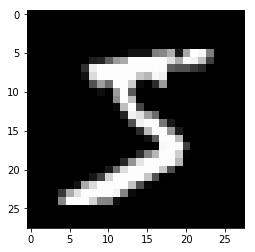

In [18]:
plt.imshow(x_train[0].reshape((28,28)), cmap="gray")
x_train.shape

In [19]:
x_train,y_train,x_valid,y_valid = map(torch.tensor, (x_train,y_train,x_valid,y_valid))
n,c = x_train.shape
x_train.shape, y_train.min(), y_train.max()

(torch.Size([50000, 784]), tensor(0), tensor(9))

In lesson2-sgd we did these things ourselves:

在第二节的sgd例子中，我们定义了以下的函数：

```python
x = torch.ones(n,2) 
def mse(y_hat, y): return ((y_hat-y)**2).mean()
y_hat = x@a
```

Now instead we'll use PyTorch's functions to do it for us, and also to handle mini-batches (which we didn't do last time, since our dataset was so small).

现在我们用PyTorch的函数来帮我们完成这个工作，并且进行数据的迷你批次处理（上次因为数据集比较小，我们没有这样做）。

In [20]:
bs=64
train_ds = TensorDataset(x_train, y_train)
valid_ds = TensorDataset(x_valid, y_valid)
data = DataBunch.create(train_ds, valid_ds, bs=bs)

In [21]:
x,y = next(iter(data.train_dl))
x.shape,y.shape

(torch.Size([64, 784]), torch.Size([64]))

In [22]:
class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(784, 10, bias=True)

    def forward(self, xb): return self.lin(xb)

In [23]:
model = Mnist_Logistic().cuda()

In [24]:
model

Mnist_Logistic(
  (lin): Linear(in_features=784, out_features=10, bias=True)
)

In [25]:
model.lin

Linear(in_features=784, out_features=10, bias=True)

In [26]:
model(x).shape

torch.Size([64, 10])

In [27]:
[p.shape for p in model.parameters()]

[torch.Size([10, 784]), torch.Size([10])]

In [28]:
lr=2e-2

In [29]:
loss_func = nn.CrossEntropyLoss()

In [30]:
def update(x,y,lr):
    wd = 1e-5
    y_hat = model(x)
    # weight decay
    w2 = 0.
    for p in model.parameters(): w2 += (p**2).sum()
    # add to regular loss
    loss = loss_func(y_hat, y) + w2*wd
    loss.backward()
    with torch.no_grad():
        for p in model.parameters():
            p.sub_(lr * p.grad)
            p.grad.zero_()
    return loss.item()

In [32]:
losses = [update(x,y,lr) for x,y in data.train_dl]

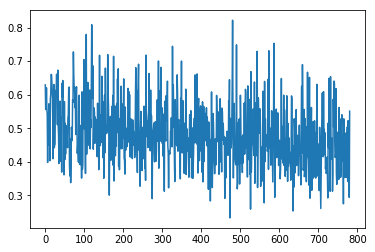

In [33]:
plt.plot(losses);

In [ ]:
class Mnist_NN(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin1 = nn.Linear(784, 50, bias=True)
        self.lin2 = nn.Linear(50, 10, bias=True)

    def forward(self, xb):
        x = self.lin1(xb)
        x = F.relu(x)
        return self.lin2(x)

In [ ]:
model = Mnist_NN().cuda()

In [ ]:
losses = [update(x,y,lr) for x,y in data.train_dl]

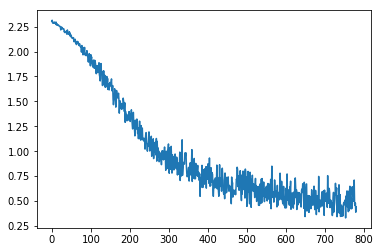

In [ ]:
plt.plot(losses);

In [ ]:
model = Mnist_NN().cuda()

In [ ]:
def update(x,y,lr):
    opt = optim.Adam(model.parameters(), lr)
    y_hat = model(x)
    loss = loss_func(y_hat, y)
    loss.backward()
    opt.step()
    opt.zero_grad()
    return loss.item()

In [ ]:
losses = [update(x,y,1e-3) for x,y in data.train_dl]

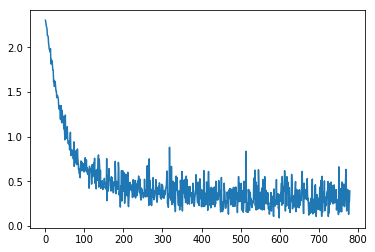

In [ ]:
plt.plot(losses);

In [ ]:
learn = Learner(data, Mnist_NN(), loss_func=loss_func, metrics=accuracy)

AttributeError: 'TensorDataset' object has no attribute 'loss_func'

In [ ]:
%debug

> /home/ubuntu/fastai/fastai/basic_data.py(20)DataLoader___getattr__()
     18 torch.utils.data.DataLoader.__init__ = intercept_args
     19 
---> 20 def DataLoader___getattr__(dl, k:str)->Any: return getattr(dl.dataset, k)
     21 DataLoader.__getattr__ = DataLoader___getattr__
     22 

ipdb> u
> /home/ubuntu/fastai/fastai/basic_data.py(38)__getattr__()
     36 
     37     def __len__(self)->int: return len(self.dl)
---> 38     def __getattr__(self,k:str)->Any: return getattr(self.dl, k)
     39     def __setstate__(self,data:Any): self.__dict__.update(data)
     40 

ipdb> print(k)
loss_func
ipdb> q


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


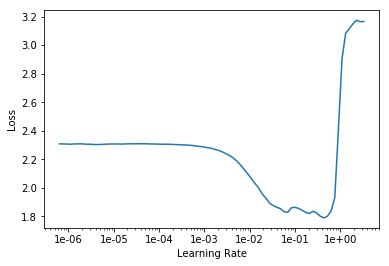

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy
1,0.129131,0.125927,0.963500


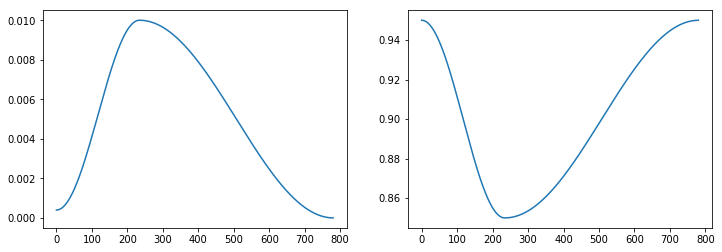

In [ ]:
learn.recorder.plot_lr(show_moms=True)

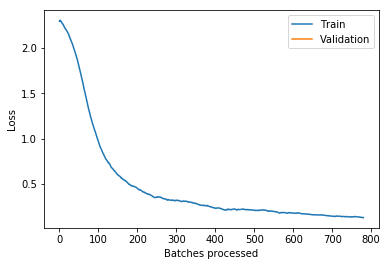

In [ ]:
learn.recorder.plot_losses()